# Objectives:

a. Perform an exploratory investigation of the data. **Identify one or two trends in the data** that are interesting from a data perspective.

    -Do the trends you observe have any effect on how you would build your **ranking feature?**
    -Are there any **inconsistencies in the data** that could have any effect on how you would build your ranking feature?  
    -How would you **communicate** these findings to a non-technical project manager?

b. How much web traffic are users' profiles receiving from internal and external sources? Is it reasonable to include both data sources in the product feature?

c. Generate a ranking for profile views. How would you present the profile view data for a "Rank for Profile Views" feature?

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()

import sklearn as sk

# Data

In [2]:
users = pd.read_csv('http://hrcdn.net/s3_pub/istreet-assets/XU-eVWAH43QNpS0y5YfYow/users.csv')
user_profile_urls = pd.read_csv('http://hrcdn.net/s3_pub/istreet-assets/ZJP4_K3y3b-Mh7FvwjLhUA/user_profile_urls.csv')
titles = pd.DataFrame(np.array([[2, 'Assistant Professor'], [1, 'Full professor'], [6, 'Other'], [3, 'Postdoctoral assistant'], [5, 'Student']]), columns=['id', 'title'])
titles['id'] = titles['id'].astype(int)
internal_profile_views = pd.read_csv('http://hrcdn.net/s3_pub/istreet-assets/P0nIDnNJq8dA-l-E4w4QgQ/internal_profile_views.csv')
external_profile_views = pd.read_csv('http://hrcdn.net/s3_pub/istreet-assets/tE7PDLQbw_chlLTwRUI_Cw/external_profile_views.csv')

In [3]:
external_profile_views.head()

,id,public_profile_url,unique_PageViews
0,1,/pub/david-brown-ms,1
1,2,/pub/julie-fremont-ms,1
2,3,/cv/tara-cutler,5
3,4,/pub/michael-morrell-ms,14
4,5,/cv/daniel-paterniti,1


In [4]:
external_profile_views.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 335636 entries, 0 to 335635
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   id                  335636 non-null  int64 
 1   public_profile_url  335636 non-null  object
 2   unique_PageViews    335636 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.7+ MB


In [5]:
# external_profile_views.to_csv('external_profile_views.csv', index=False)

# Part 1: Exploratory Investigation of the Data

The product manager has some questions on the data and is looking to you for some insight. Please provide your answer (and any applicable SQL queries you used to arrive at the answer):

1. What is the average age of users by region?

```
SELECT region
, ROUND(AVG(age)) AS average_age
FROM doximity.users
GROUP BY 1
ORDER BY 2 DESC
```
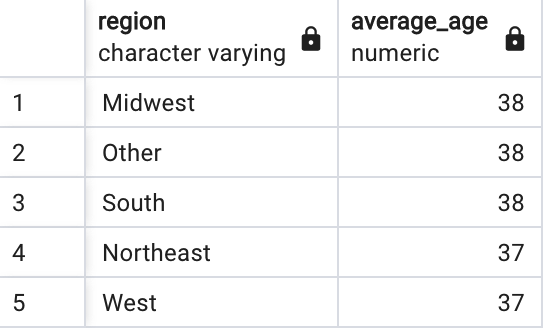

1. Could you provide a breakdown of user title and number of user counts associated with each title?

```
SELECT title
, COUNT(*) AS title_count
FROM doximity.user_titles
JOIN doximity.users
ON doximity.user_titles.id = doximity.users.title_id
GROUP BY 1
ORDER BY 2 DESC
```
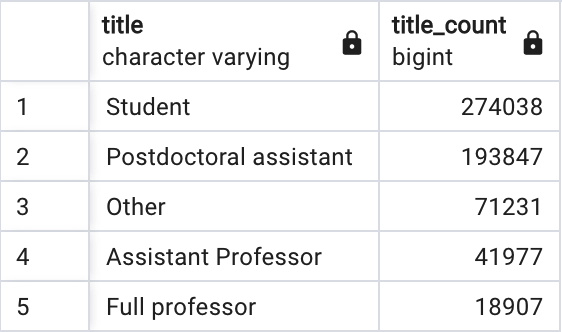

2. Who is the top viewed user, based on internal profile views?

```
SELECT viewed_user_id
, COUNT(*) AS internal_profile_views
FROM doximity.internal_profile_views
GROUP BY 1
ORDER BY 2 DESC
LIMIT 1
```
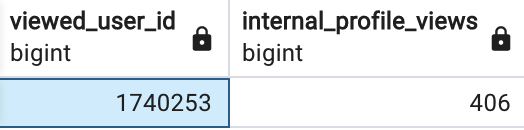

1. Can you provide a ranked list of the top 10 most viewed users based on internal profile views, supplemented with data from the user table?

```
WITH views AS (
SELECT viewed_user_id
, firstname
, lastname
, age
, region
, title_id
, COUNT(*) AS view_count
FROM doximity.internal_profile_views AS ipv
JOIN doximity.users AS u
ON ipv.viewed_user_id = u.id
GROUP BY 1, 2, 3, 4, 5, 6
)

, prof_view_rank AS (
SELECT *
, RANK() OVER (ORDER BY view_count DESC) AS view_rank
FROM views
)

SELECT viewed_user_id
, firstname
, lastname
, age
, region
, title_id
, view_count
, view_rank
FROM prof_view_rank
WHERE view_rank <= 10
```
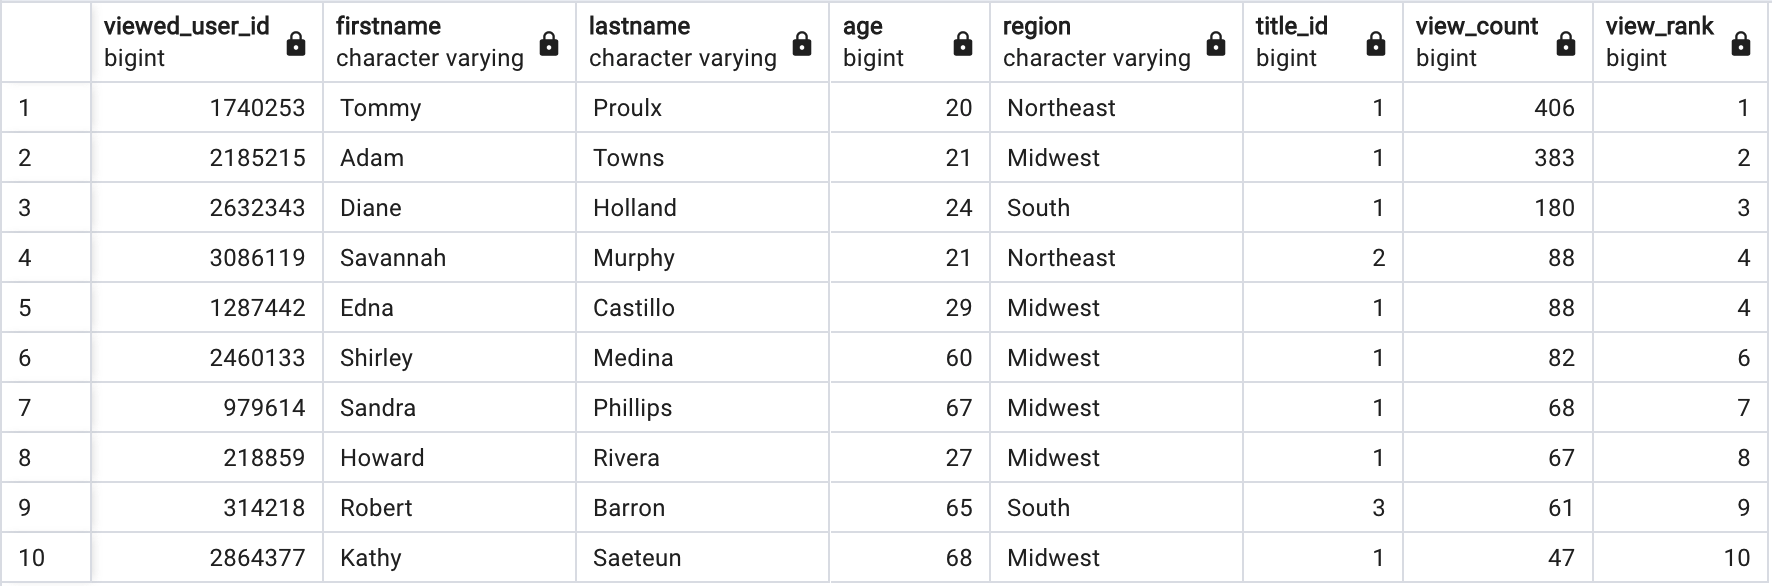

1. Extra: Of top 10 internal views, which regions do they come from?

```
WITH views AS (
SELECT viewed_user_id
, firstname
, lastname
, age
, region
, title_id
, COUNT(*) AS view_count
FROM doximity.internal_profile_views AS ipv
JOIN doximity.users AS u
ON ipv.viewed_user_id = u.id
GROUP BY 1, 2, 3, 4, 5, 6
)

, prof_view_rank AS (
SELECT *
, RANK() OVER (ORDER BY view_count DESC) AS view_rank
FROM views
)

, top_ten AS (
SELECT viewed_user_id
, firstname
, lastname
, age
, region
, title_id
, view_count
, view_rank
FROM prof_view_rank
WHERE view_rank <= 10
)
	
SELECT region
, COUNT(*) AS region_count
FROM top_ten
GROUP BY 1
```
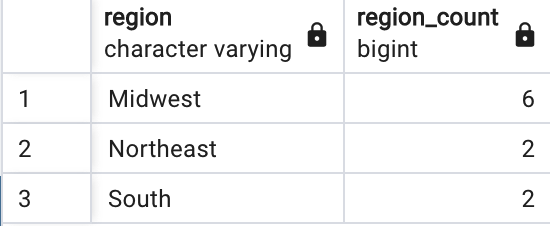

1. Which region gets the most viewed users (based on internal profile views)?

```
WITH views AS (
SELECT viewed_user_id
, region
, COUNT(*) AS view_count
FROM doximity.internal_profile_views AS ipv
JOIN doximity.users AS u
ON ipv.viewed_user_id = u.id
GROUP BY 1, 2
)

SELECT region
FROM views
ORDER BY view_count DESC
LIMIT 1		
```
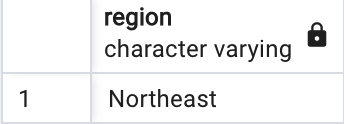

1. Extra: What age brackets belong to 1-5 and 6-10 top-ranked internal profile views? (Top 5: all in their 20's. Bottom 5: mostly in 60's except for top 8 has users in their 20's)

```
WITH views AS (
SELECT viewed_user_id
, SUM(CASE WHEN AGE BETWEEN 20 AND 29 THEN 1 ELSE 0 END) AS twenties
, SUM(CASE WHEN AGE BETWEEN 30 AND 39 THEN 1 ELSE 0 END) AS thirties
, SUM(CASE WHEN AGE BETWEEN 40 AND 49 THEN 1 ELSE 0 END) AS forties
, SUM(CASE WHEN AGE BETWEEN 50 AND 59 THEN 1 ELSE 0 END) AS fifties
, SUM(CASE WHEN AGE BETWEEN 60 AND 69 THEN 1 ELSE 0 END) AS sixties
, SUM(CASE WHEN AGE BETWEEN 70 AND 79 THEN 1 ELSE 0 END) AS seventies
, SUM(CASE WHEN AGE BETWEEN 80 AND 89 THEN 1 ELSE 0 END) AS eighties
, COUNT(*) AS view_count
FROM doximity.internal_profile_views AS ipv
JOIN doximity.users AS u
ON ipv.viewed_user_id = u.id
GROUP BY 1
)

SELECT *
FROM views
ORDER BY view_count DESC
```

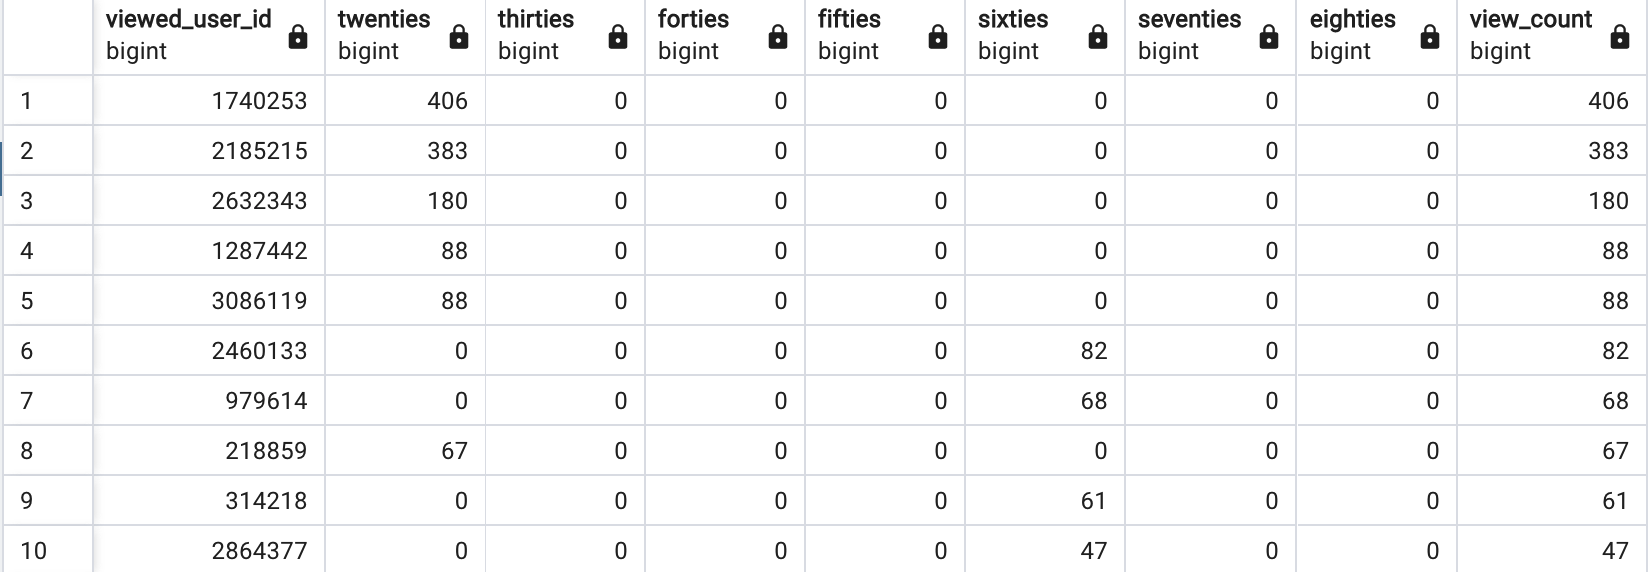

1. Extra: How many views for a profle page from external and internal network users?

```
WITH internal_view_urls AS (
SELECT profile_url
, COUNT(*) internal_view_count
FROM doximity.internal_profile_views AS ipv
JOIN doximity.users AS u
ON ipv.viewed_user_id = u.id
JOIN doximity.user_profile_urls AS upu
ON u.id = upu.user_id
GROUP BY 1
ORDER BY 2 DESC
)

SELECT public_profile_url
, CASE WHEN internal_view_count IS NOT NULL 
THEN "unique_PageViews" + internal_view_count
ELSE "unique_PageViews" 
END AS ext_and_int_pg_views
FROM doximity.external_profile_views epv
LEFT JOIN internal_view_urls AS ivu
ON ivu.profile_url = epv.public_profile_url
ORDER BY 2 DESC
```

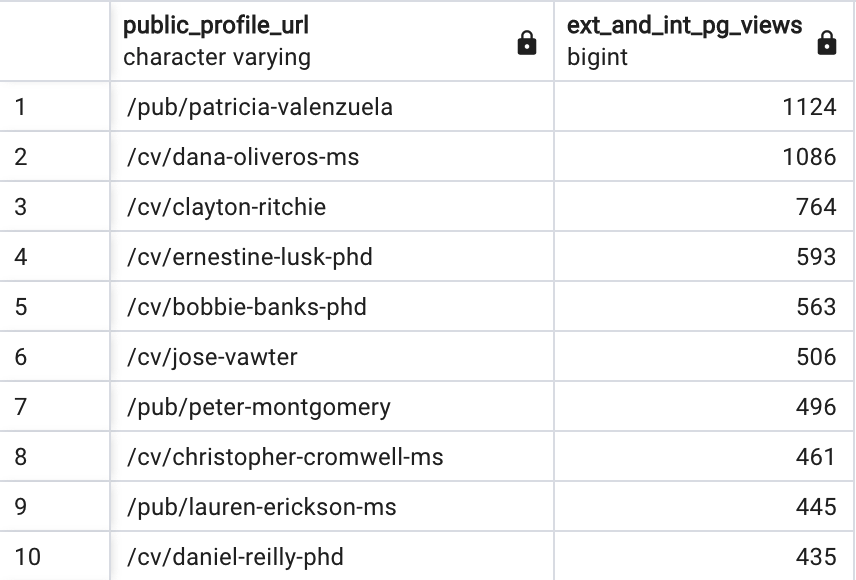

1. Extra: Percentage of external and internal profile view page types

```
WITH internal_view_urls AS (
SELECT profile_url
, COUNT(*) internal_view_count
FROM doximity.internal_profile_views AS ipv
JOIN doximity.users AS u
ON ipv.viewed_user_id = u.id
JOIN doximity.user_profile_urls AS upu
ON u.id = upu.user_id
GROUP BY 1
ORDER BY 2 DESC
)

, page_types AS (
SELECT public_profile_url
, CASE WHEN internal_view_count IS NOT NULL 
THEN "unique_PageViews" + internal_view_count
ELSE "unique_PageViews" 
END AS ext_and_int_pg_views
, SUM(CASE WHEN public_profile_url LIKE '/pub%' THEN 1 ELSE 0 END) OVER () AS total_pub 
, SUM(CASE WHEN public_profile_url LIKE '/cv%' THEN 1 ELSE 0 END) OVER () AS total_cv
, COUNT(public_profile_url) OVER () AS total_profiles
FROM doximity.external_profile_views epv
LEFT JOIN internal_view_urls AS ivu
ON ivu.profile_url = epv.public_profile_url
GROUP BY 1, 2
ORDER BY 2 DESC
)

SELECT ROUND(CAST(total_pub AS DECIMAL)/total_profiles * 100, 2) AS total_pub_pct
, ROUND(CAST(total_cv AS DECIMAL)/total_profiles * 100, 2) AS total_cv_pct
FROM page_types
LIMIT 1
```
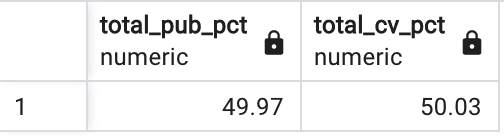

1. Extra: Percentage of external and internal profile view page types - top 10

```
WITH internal_view_urls AS (
SELECT profile_url
, COUNT(*) internal_view_count
FROM doximity.internal_profile_views AS ipv
JOIN doximity.users AS u
ON ipv.viewed_user_id = u.id
JOIN doximity.user_profile_urls AS upu
ON u.id = upu.user_id
GROUP BY 1
ORDER BY 2 DESC
)

, page_types_top10 AS (
SELECT public_profile_url
, CASE WHEN internal_view_count IS NOT NULL 
THEN "unique_PageViews" + internal_view_count
ELSE "unique_PageViews" 
END AS ext_and_int_pg_views
FROM doximity.external_profile_views epv
LEFT JOIN internal_view_urls AS ivu
ON ivu.profile_url = epv.public_profile_url
GROUP BY 1, 2
ORDER BY 2 DESC
LIMIT 10
)

, types_agg AS (
SELECT *
, SUM(CASE WHEN public_profile_url LIKE '/pub%' THEN 1 ELSE 0 END) OVER () AS total_pub 
, SUM(CASE WHEN public_profile_url LIKE '/cv%' THEN 1 ELSE 0 END) OVER () AS total_cv
, COUNT(public_profile_url) OVER () AS total_profiles
FROM page_types_top10
)

SELECT ROUND(CAST(total_pub AS DECIMAL)/total_profiles * 100, 2) AS total_pub_pct
, ROUND(CAST(total_cv AS DECIMAL)/total_profiles * 100, 2) AS total_cv_pct
FROM types_agg
LIMIT 1
```

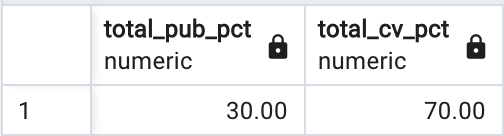

1. What is the region, age and titles of those who have public and in-network profiles with hits?

```
WITH internal_view_urls AS (
SELECT profile_url AS viewed_url
, region
, age
, title
, COUNT(*) internal_view_count
FROM doximity.internal_profile_views AS ipv
JOIN doximity.users AS u
ON ipv.viewed_user_id = u.id
JOIN doximity.user_profile_urls AS upu
ON u.id = upu.user_id
JOIN doximity.user_titles AS ut
ON u.title_id = ut.id
GROUP BY 1, 2, 3, 4
ORDER BY 5 DESC
)

SELECT public_profile_url
, region
, age
, title
, internal_view_count
, CASE WHEN internal_view_count IS NOT NULL 
THEN "unique_PageViews" + internal_view_count
ELSE "unique_PageViews" 
END AS ext_and_int_pg_views
FROM doximity.external_profile_views epv
LEFT JOIN internal_view_urls AS ivu
ON ivu.viewed_url = epv.public_profile_url
WHERE region IS NOT NULL
ORDER BY 6 DESC
```

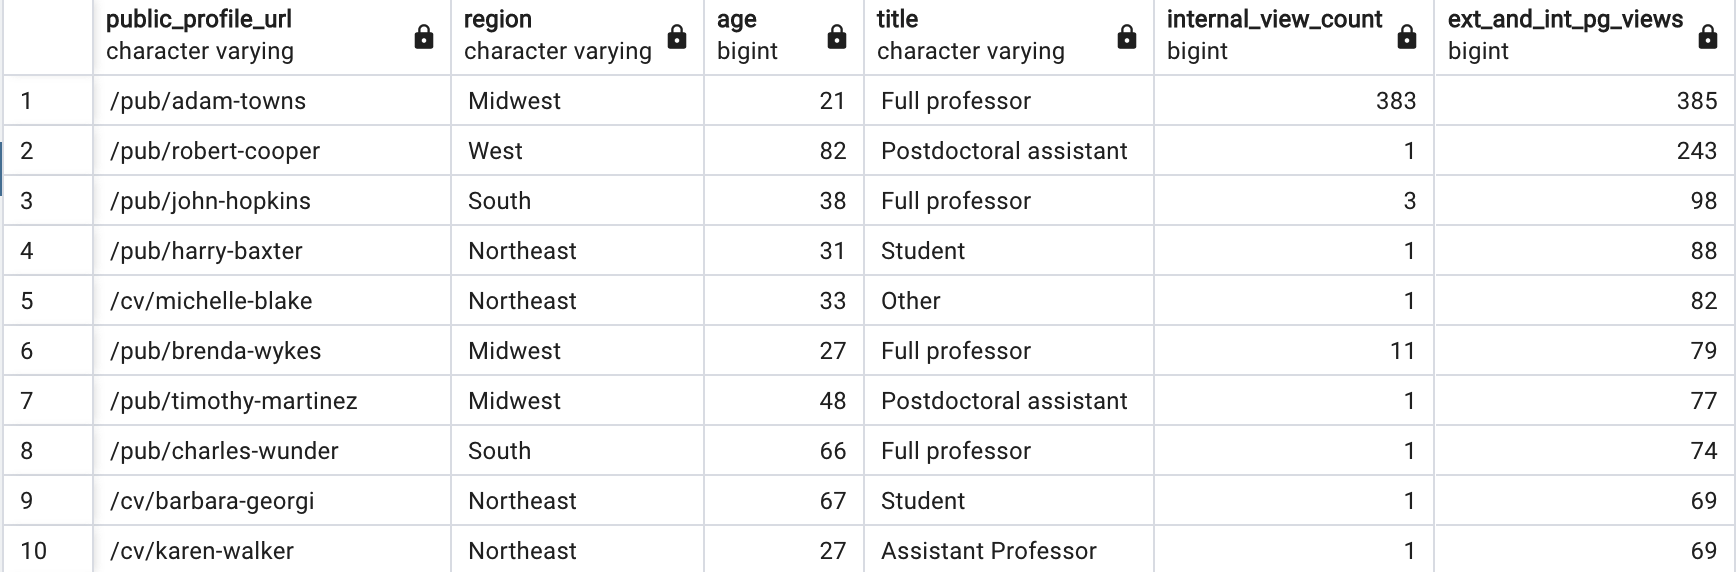

# Building Ranking Feature for Social Network like LinkedIn

# Challenge Scenario

Consider a scenario where you work for a social network company for academics. This social network includes full professors, assistant professors, postdoctoral students, graduate students and others as members. To <font color='red'> increase engagement and interaction </font> among the members of this academic community, your product manager wants to roll out a <font color='red'>feature that ranks members in the network according to the number of times other people have viewed their social profiles</font>. The product manager sketches out a general vision for the product, which would appear differently for each user:

Your rank for profile views

1. Jane Doe
1. John Doe
1. You
1. Jon Doe
1. Jan Doe
1. ...

# Part 2: 

With the given data, your goals are to understand and help the product manager understand:

1. how users are interacting with each others’ profiles
2. how much web traffic user profiles are receiving and from where 

to pull the data in a form that can generate a “Rank for profile views” feature, and to postulate how the data may best be presented in this product.

To this end, you should create:

1. one or two data visualizations to help the product manager understand the social network’s profile views data 
2. and write a brief summary communicating how the data may be used to drive the product forward. 

# Summary of expectations

This problem is very open-ended, so feel free to investigate questions of your own that may help address the needs of the product/product manager. Below are two guideline questions that you may use for starters:

1. What is the most interesting insight or opportunity that you discovered?
1. What possible improvements to the data would you like to make?

** We suggest you spend no more than five hours to complete this challenge. It's likely you won't have time to include everything you wanted (or perhaps even answer all questions in the challenge), and that's ok. Please submit all the code you wrote, your data visualizations (we love Jupyter notebooks, but feel free to submit in other formats, e.g. Word docs), and answers to the questions via email (instructions below). We hope this exercise is helpful (maybe even fun!) for you and appreciate your taking the time to do it! **

<AxesSubplot:xlabel='viewed_user_id'>

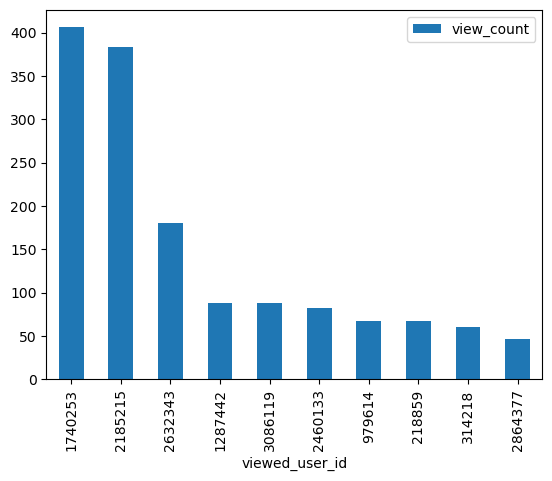

In [6]:
top10internal_views = pd.read_csv('/kaggle/input/doximity/internal_views_count_rank.csv')
top10internal_views.plot(x = 'viewed_user_id', y = 'view_count', kind = 'bar')

<AxesSubplot:xlabel='region'>

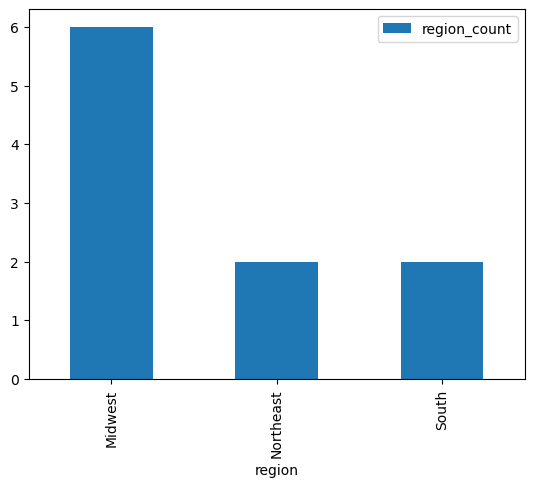

In [7]:
top10internal_regions = pd.read_csv('/kaggle/input/doximity/top10internal_regions.csv')
top10internal_regions.plot(x = 'region', y = 'region_count', kind = 'bar')

<AxesSubplot:xlabel='public_profile_url'>

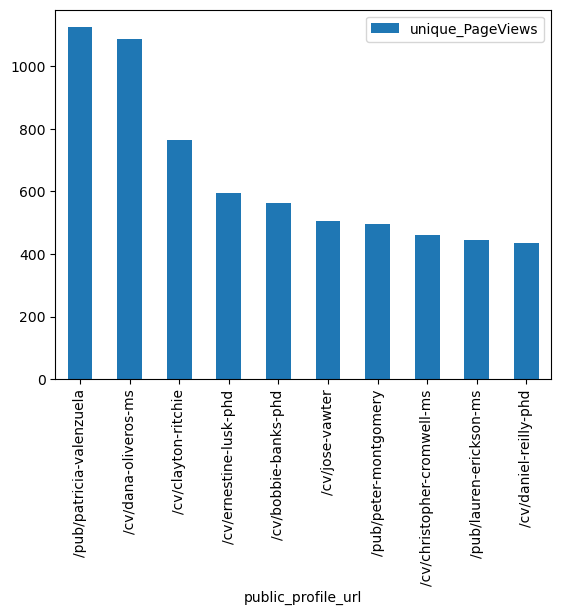

In [8]:
external_views = pd.read_csv('/kaggle/input/doximity/external_views_url.csv')
external_views_top10 = external_views.sort_values(['unique_PageViews'], ascending=[False]).head(10)
external_views_top10.plot(x = 'public_profile_url', y = 'unique_PageViews', kind = 'bar')

<AxesSubplot:xlabel='public_profile_url'>

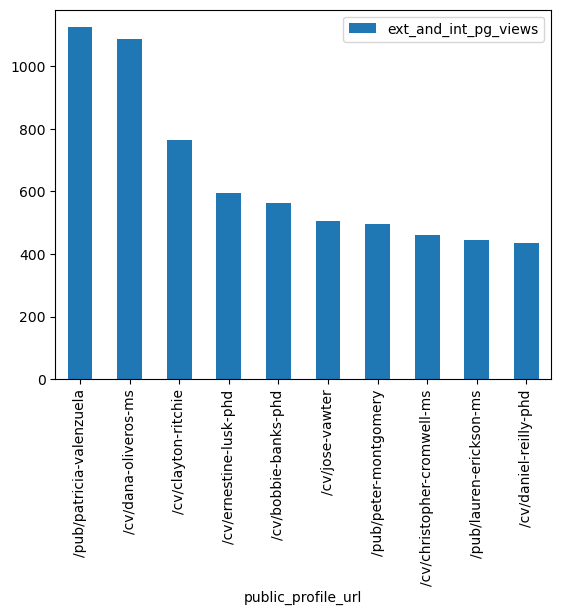

In [9]:
external_internal_views = pd.read_csv('/kaggle/input/doximity/external_internal_pg_cnt.csv')
external_internal_views_top10 = external_internal_views.sort_values(['ext_and_int_pg_views'], ascending=[False]).head(10)
external_internal_views_top10.plot(x = 'public_profile_url', y = 'ext_and_int_pg_views', kind = 'bar')

# Observations

1. Most users are in their late 30's.
2. Most users are students/postdoctoral assistants.
3. Most internal views come from the Midwest. So the social network is the huge in that region of the U.S.
4. Interesting that the most internal views come from users who are in their 20's and retirement age.
5. Type of pages that are being hit are even around pub and cv.
6. For most hits overall including external and internal, most pages are full professors, from the Northeast, around the age of 44. 
7. Even though there are users who have a profile exposed to outsiders and those within the social network, hits are either high in internal/external, but not mixed between both sources.

# Conclusion

a. Perform an exploratory investigation of the data. **Identify one or two trends in the data** that are interesting from a data perspective.

    -Do the trends you observe have any effect on how you would build your **ranking feature?**
    
    Trends observed would have an effect on how I would build my ranking feature. This is because ordering a users' search results would be based on two things: 
    1. relevance of the profiles 
    2. what is the most relevant based on most viewed profiles (just within network/external/both)
    
    Given, there are not that many internal views compared to views based on search engine result hits, would supplement ranking with external views. Also, whichever region, title, age is of the user has to match the searchers' query intent. For example:
    
# Ranking Feature Would be Based On:

* Query Intent

Different Types of Query Intent | data that would be relevant to answer that query
1. Looking for Peers | region, title, age
2. Looking for Mentors | region, title, age
3. Looking for doctor to help with rare disease care | title
4. finding jobs | region (if not telehealth), title
    
    -Are there any **inconsistencies in the data** that could have any effect on how you would build your ranking feature?  
    
A huge inconsistency in the data that would have an effect on how I would build out my ranking feature is how there are not as many internal page views compared to profile views coming from outside network.
 
    -How would you **communicate** these findings to a non-technical project manager?
    
I would communicate these findings to a non-technical project manager by talking at a high level focusing on users, their behavior and how insights on them influence how to rank profiles in a search result. Visualizations will help summarize and answer non-technical project manager's questions.

b. How much web traffic are users' profiles receiving from internal and external sources? Is it reasonable to include both data sources in the product feature?

Web traffic is significantly more than internal source for profile hits. It is reasonable to include both data sources - internal and external in the product feature even though there are only less than 1% of users on platform that are public profiles. Most profile hits are coming from search engine results. So if internal views were the only ones included, would not have enough user profile engagement to provide a highly probably search result that matches users' query intent.

c. Generate a ranking for profile views. How would you present the profile view data for a "Rank for Profile Views" feature?

1. For each user profile data that matches relevant data needed to answer query intent, include in relevant pool of user profiles
2. Weigh each relevant data metric (region, title)
3. Get a score for each data metric/user and sum score/user
4. For ranked search result: Order profiles based on sum score with highest at the top

# Recommendation: 
1. increase internal user hits 
2. get more demographic data to increase ability to extract good signal when new connection is made
3. increase engagement by having more internal user profiles public
4. by honing in on query intent, providing personalized profile rankings based on a user's demographics and past search behavior, can increase likelihood of correct profile ranking and therefore increase user engagement/interaction